In [ ]:
! pip install pyspark --quiet

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 59.0 MB/s 


In [ ]:
! wget https://github.com/trangtong/ub_sample_data/raw/main/ub_sample_data.csv

--2022-06-15 07:47:50--  https://github.com/trangtong/ub_sample_data/raw/main/ub_sample_data.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trangtong/ub_sample_data/main/ub_sample_data.csv [following]
--2022-06-15 07:47:50--  https://raw.githubusercontent.com/trangtong/ub_sample_data/main/ub_sample_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1777828 (1.7M) [text/plain]
Saving to: ‘ub_sample_data.csv’

ub_sample_data.csv  100%[===================>]   1.70M  --.-KB/s    in 0.03s   

2022-06-15 07:47:50 (55.3 MB/s) - ‘ub_sample_data.csv’ saved [1777828/1777828]



#Xử lý dữ liệu Raw

In [ ]:
import pyspark
import itertools

In [ ]:
sc = pyspark.SparkContext()
sql_cont=pyspark.sql.SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
rdd= sc.textFile('/content/ub_sample_data.csv')
header = rdd.first()


In [ ]:
threshold = 7
df=rdd.filter(lambda x:x!= header).map(lambda x:x.split(',')).groupByKey().mapValues(set).filter(lambda x:len(x[1])>=threshold).cache()
df2=df.collectAsMap()
pairs=[]

for i in itertools.combinations(df.map(lambda x:x[0]).collect(),2):
    intersection_pairs=set(df2[i[0]]).intersection(set(df2[i[1]]))
    if len(intersection_pairs)>=threshold:
        #pairs.extend([(i[0],i[1]),(i[1],i[0])])
        pairs.extend([(i[0],i[1])])

In [ ]:
p=sc.parallelize(pairs).flatMap(lambda x:x).distinct().map(lambda x:(x,1)).collect()
vertices=sql_cont.createDataFrame(p,["id","djhkg"])
edges=sql_cont.createDataFrame(pairs,["src","dst"])

#Dựng đồ thị Bằng NetworkX

In [ ]:
import networkx as nx
graph = nx.from_pandas_edgelist(edges.toPandas(), 'src', 'dst')

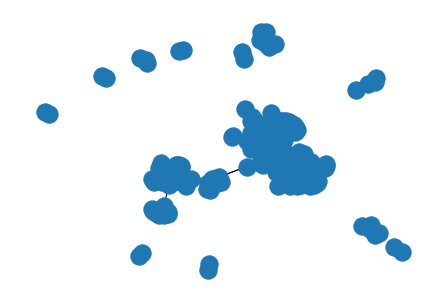

In [ ]:
nx.draw(graph)

#Between Calculation

In [ ]:
with open("between.txt", 'w') as output:
  for test in nx.edge_betweenness_centrality(graph).items():
    out = list(test)
    print(*out, file=output)
  output.close()

#Community Detection bằng thuật toán Girvan Newman

In [ ]:
from random import random
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    max_cent = max(centrality.values())
    centrality = {e: c / max_cent for e, c in centrality.items()}
    centrality = {e: c + random() for e, c in centrality.items()}
    return max(centrality, key=centrality.get)

In [ ]:
copy = graph
community = nx.algorithms.community.girvan_newman(copy, most_central_edge)
communities = tuple(sorted(com) for com in next(community))


In [ ]:
#Số lượng community
len(communities)

14

In [ ]:
with open("community.txt",'w') as outfile:
  for c in communities:
    print(c, file=outfile)
  outfile.close()

In [ ]:
# modularity
nx.community.modularity(copy, communities)

0.5235076853599138

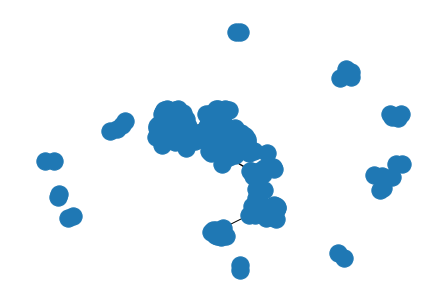

In [ ]:
nx.draw(copy)

#Tài liệu tham khảo

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html - networkx Girvan Newman